# OOS Predictive Performance of SLOPE

## Outline of the steps in this section:
In here, trading strategy with straddles is looked at

- Note cumulative returns for two trading strategies using S&P500 straddles.
    1) Unconditionally selling S&P500 straddles with a constant maturity of 30 days 
        Calculate the returns slightly different: r_shortStraddle = (straddle_t - straddle_t+1)/(0.2 * SP500_t)
        So I need to interpolate a bit different
        Should be substantially positive --> make graph, calculate sharpe ratio, average return and volatility
    2) Conditional strategy using SLOPE as an indicator for whether to buy or sell straddles.
        For 1996 - 1999 training period:
        Compute SLOPE_t using PCA on VIX term structure data from beginning of sample to t
        If SLOPE_t in bottom quintile of historical distribution, buy straddles at t, sell at t+1. Otherwise, short at t, buy             back at t+1
        Should be substantially positive --> make graph, calculate sharpe ratio, average return and volatility
Compare the two strategies, mark in graph where it is different, maybe even a line with the spot price
Play around with the training / test window
What happens when we take another model than PCA?
Exclude Financial crisis? 
Effect Covid?
Own strategy? short 30 day, long 360 day and otherway around? compare sharpe_ratio

In [194]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pandas as pd
import numpy as np
import sqlalchemy as db
import sys
from scipy.interpolate import interp1d
import os
from datetime import datetime, timedelta
from scipy.stats import norm
import math
import matplotlib.dates as mdates

In [195]:
# Import all our data we want to work within this section
#File paths for the CSV files
file_path1 = 'Data/Straddles/short_straddle_returns_correct.csv'
file_path2 = 'Data/Author_Data/STRADDLE_RET.csv'

# Reading the CSV files into Pandas DataFrames
returns_short = pd.read_csv(file_path1)
returns_short['Date'] = pd.to_datetime(returns_short['Date'])

# his given returns include long and short returns (name differ accordingly)
STRADDLE_RET_given = pd.read_csv(file_path2, skiprows=6)
STRADDLE_RET_given['Date'] = pd.to_datetime(STRADDLE_RET_given['Date'], format='%Y%m%d').dt.strftime('%Y-%m-%d')
STRADDLE_RET_given['Date'] = pd.to_datetime(STRADDLE_RET_given['Date'])
STRADDLE_RET_given[STRADDLE_RET_given.columns[1:]] = STRADDLE_RET_given[STRADDLE_RET_given.columns[1:]]/100

## Short variance only
First, we calculate the returns for the full period for the unconditional strategy.

In [196]:
# produce a graph with the cumulative performance of unconditionally shorting the straddles
# Calculate cumulative performance starting from 1 at the first date (1996-01-05)
returns_short['cumulative_performance_1'] = (1 + returns_short['r_v_30']).cumprod()
returns_short['cumulative_performance_2'] = (1 + returns_short['r_v_60']).cumprod()
returns_short['cumulative_performance_3'] = (1 + returns_short['r_v_90']).cumprod()
returns_short['cumulative_performance_6'] = (1 + returns_short['r_v_180']).cumprod()
returns_short['cumulative_performance_9'] = (1 + returns_short['r_v_270']).cumprod()
returns_short['cumulative_performance_12'] = (1 + returns_short['r_v_360']).cumprod()

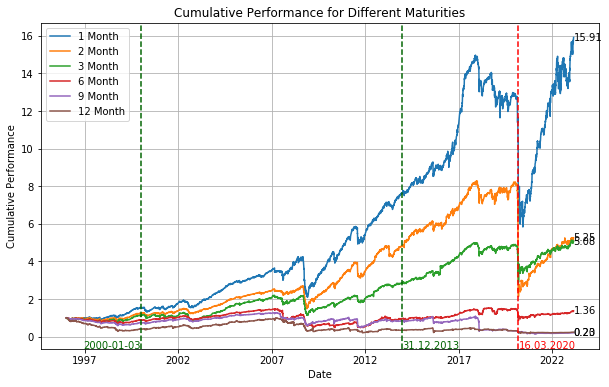

In [197]:
# Plotting the cumulative performances for our data
plt.figure(figsize=(10, 6))
maturity_columns = [1, 2, 3, 6, 9, 12]
# Plot each line for different durations
for mat in maturity_columns:
    plt.plot(returns_short['Date'], returns_short[f'cumulative_performance_{mat}'], label=f'{mat} Month')

    # Add text annotations for the end value of each line
    end_value = returns_short[f'cumulative_performance_{mat}'].iloc[-1]
    plt.text(returns_short['Date'].iloc[-1], end_value, f'{end_value:.2f}', va='center', ha='left')

years = pd.date_range(start='1996-01-05', end='2022-01-05', freq='5YS')  # Generating year starts
plt.xticks(years, [year.year for year in years])

plt.axvline(pd.to_datetime('2013-12-31'), color='darkgreen', linestyle='--')
plt.text(pd.to_datetime('2013-12-31'), plt.gca().get_ylim()[0], '31.12.2013', color='darkgreen', ha='left')
plt.axvline(pd.to_datetime('2000-01-03'), color='darkgreen', linestyle='--')
plt.text(pd.to_datetime('2000-01-03'), plt.gca().get_ylim()[0], '2000-01-03', color='darkgreen', ha='right')
plt.axvline(pd.to_datetime('2020-03-16'), color='red', linestyle='--')
plt.text(pd.to_datetime('2020-03-16'), plt.gca().get_ylim()[0], '16.03.2020', color='red', ha='left')

plt.title('Cumulative Performance for Different Maturities')
plt.xlabel('Date')
plt.ylabel('Cumulative Performance')
plt.legend()
plt.grid(True)
plt.show()

In [198]:
# same for his data
STRADDLE_RET_given['cumulative_performance_1'] = (1 + STRADDLE_RET_given['r_1^{short straddle}']).cumprod()
STRADDLE_RET_given['cumulative_performance_2'] = (1 + STRADDLE_RET_given['r_2^{short straddle}']).cumprod()
STRADDLE_RET_given['cumulative_performance_3'] = (1 + STRADDLE_RET_given['r_3^{short straddle}']).cumprod()
STRADDLE_RET_given['cumulative_performance_6'] = (1 + STRADDLE_RET_given['r_6^{short straddle}']).cumprod()
STRADDLE_RET_given['cumulative_performance_9'] = (1 + STRADDLE_RET_given['r_9^{short straddle}']).cumprod()
STRADDLE_RET_given['cumulative_performance_12'] = (1 + STRADDLE_RET_given['r_12^{short straddle}']).cumprod()

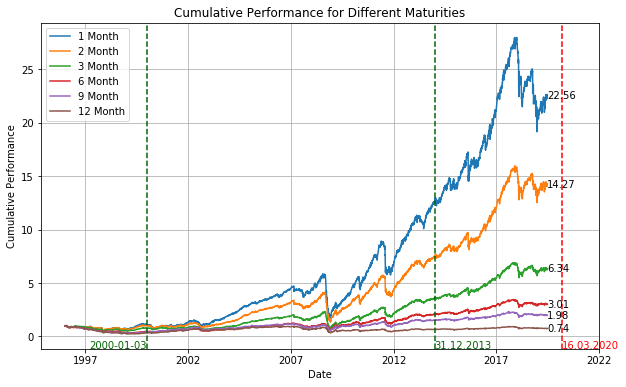

In [199]:
# Plotting the cumulative performances for his data
plt.figure(figsize=(10, 6))
maturity_columns = [1, 2, 3, 6, 9, 12]

# Plot each line for different durations
for mat in maturity_columns:
    plt.plot(STRADDLE_RET_given['Date'], STRADDLE_RET_given[f'cumulative_performance_{mat}'], label=f'{mat} Month')

    # Add text annotations for the end value of each line
    end_value = STRADDLE_RET_given[f'cumulative_performance_{mat}'].iloc[-1]
    plt.text(STRADDLE_RET_given['Date'].iloc[-1], end_value, f'{end_value:.2f}', va='center', ha='left')

years = pd.date_range(start='1996-01-05', end='2022-01-05', freq='5YS')  # Generating year starts
plt.xticks(years, [year.year for year in years])

plt.axvline(pd.to_datetime('2013-12-31'), color='darkgreen', linestyle='--')
plt.text(pd.to_datetime('2013-12-31'), plt.gca().get_ylim()[0], '31.12.2013', color='darkgreen', ha='left')
plt.axvline(pd.to_datetime('2000-01-03'), color='darkgreen', linestyle='--')
plt.text(pd.to_datetime('2000-01-03'), plt.gca().get_ylim()[0], '2000-01-03', color='darkgreen', ha='right')
plt.axvline(pd.to_datetime('2020-03-16'), color='red', linestyle='--')
plt.text(pd.to_datetime('2020-03-16'), plt.gca().get_ylim()[0], '16.03.2020', color='red', ha='left')

plt.title('Cumulative Performance for Different Maturities')
plt.xlabel('Date')
plt.ylabel('Cumulative Performance')
plt.legend()
plt.grid(True)
plt.show()
#his dataset is only until 2019

One can clearly see that we are unfortunately need able to replicate his data 1:1. The characteristics, however, look to be the same.
Again, in the paper, the performance graph start at the beginning of 2000 and only leads to end 2013. See the period in darkgreen. To actually compare it though, one would need to recalculate the full performance to start at 1 in the beginning of 2000.

# Now to the conditional performance of the strategy
Conditional strategy using SLOPE as an indicator for whether to buy or sell straddles.
For 1996 - 1999 training period:
Compute SLOPE_t using PCA on VIX term structure data from beginning of sample to t
If SLOPE_t in bottom quintile of historical distribution, buy straddles at t, sell at t+1. Otherwise, short at t, buy             back at t+1. Watch out for the look ahead bias!!!
Should be substantially positive --> make graph, calculate sharpe ratio, average return and volatility
The paper uses a training (in-sample) and testperiod (out-of-sample) for the conditional strategy, and the graph is just from beginning of 2000 to 2013 (even though data would have been available up until 2019).

In this next session, I am only working with the 30 day data. The codes can however just be reused for other maturities

In [200]:
# File paths for the PCA slope data
file_path = 'Data/PCA_custom.csv'
file_path1 = 'Data/Author_Data/PCA.csv'

# Reading the CSV files into Pandas DataFrames and only store the column that is needed for the conditional strategy (Slope)
SLOPE = pd.read_csv(file_path)
SLOPE['Date'] = pd.to_datetime(SLOPE['Date'])

SLOPE_given = pd.read_csv(file_path1,skiprows=12)
SLOPE_given['Date'] = pd.to_datetime(SLOPE_given['Date'], format='%Y%m%d').dt.strftime('%Y-%m-%d')
#PCA.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
#PCA = PCA.drop(['Unnamed: 7'], axis=1)
#PCA['Date'] = pd.to_datetime(PCA['Date'], format='%Y%m%d').dt.strftime('%Y-%m-%d')
#SLOPE = PCA[['Date', 'PC2']].copy()
#SLOPE.rename(columns={'PC2': 'Slope'}, inplace=True)

In [201]:
# Import the returns from the long straddle return
# File paths for the CSV files
file_path1 = 'Data/Straddles/straddle_returns_correct.csv'

#straddle_returns_correct is with the correct weighting, _final with the wrong (which is closer to his data)
# Reading the CSV files into Pandas DataFrames
returns_long = pd.read_csv(file_path1)
returns_long = returns_long.rename(columns={'date': 'Date'})
returns_long['Date'] = pd.to_datetime(returns_long['Date'])

# some modifications such that the datasets are consistent
returns_long = returns_long.drop(returns_long.index[-1])
dates_to_drop = ['1999-01-19','2000-09-15', '2000-09-18'] # dates that are in SLOPE but not in the other two datasets
SLOPE = SLOPE[~SLOPE['Date'].isin(dates_to_drop)] #drop these dates
#SLOPE still includes 1996-01-04 and 2023-02-28, so the first and last observation. We keep these,
#because it needs to be shifted later on anyway

## Option1: Expanding window
Here in the first approach, we compute the quintile based on the historical distribution from expanding the window day-to-day.
We compute the signal based on the condition: True = take the long return (as the current SLOPE value is in the bottom quintile), False = take the short return (as the current SLOPE value is not in the bottom quintile).

In [202]:
# Here, the actual signal is computed
# I get the signal from continously comparing the current value of slope to the historical distribution UP TO t. 
# So in my opinion, there is no need to split up the dataset into training and test data.

# Replace or drop missing values in the 'Slope' column
SLOPE['Slope'].fillna(method='ffill', inplace=True)  # Forward fill NaN values
# Convert 'Date' column to datetime if it's not already in datetime format
#SLOPE['Date'] = pd.to_datetime(SLOPE['Date'])

# Initialize a list to hold the boolean values for each row
in_bottom_quintile = []

# Calculate quantile based on historical data up until date 't' for each observation
for i in range(len(SLOPE)):
    # Select the data up to the current row's date
    slope_data = SLOPE.loc[SLOPE['Date'] <= SLOPE.iloc[i]['Date']]
    #print(i)
    #print("Slope: ",slope_data)
    if len(slope_data) > 1:
        current_value = slope_data.iloc[-1]['Slope']
        #print("Current value: ", current_value)
        historical_values = slope_data.iloc[:-1]['Slope']
        #print("Historical values: ", historical_values)
        quantile = historical_values.quantile(0.2)
        #print('Quantile: ', quantile)
        in_bottom_quintile.append(current_value <= quantile)
        #print(f"True/False_{i}: ", in_bottom_quintile)
    else:
        in_bottom_quintile.append(True)  # Set as True if insufficient data for quantile calculation

# Assign the list to a new column 'InBottomQuintile'
SLOPE['InBottomQuintile'] = in_bottom_quintile

In [203]:
print("    Share of short (false) and long (true) for the bottom quintile")
value_counts = SLOPE['InBottomQuintile'].value_counts()
print(value_counts/sum(value_counts))

    Share of short (false) and long (true) for the bottom quintile
False    0.903835
True     0.096165
Name: InBottomQuintile, dtype: float64


In [204]:
# SLOPE['Date'] = pd.to_datetime(SLOPE['Date']) done above already
# returns_long_correct['Date'] = pd.to_datetime(returns_long_correct['Date'])
# STRADDLE_RET['Date'] = pd.to_datetime(STRADDLE_RET['Date']) applied above already
#merge the datasets
returns_long_short_30 = pd.merge(returns_long[['Date', 'return_30']], returns_short[['Date','r_v_30']], on='Date', how='inner')
returns_long_short_30 = returns_long_short_30.merge(SLOPE[['Date', 'InBottomQuintile']], on='Date')
#shift to account for the look ahead bias
returns_long_short_30['InBottomQuintile'] = returns_long_short_30['InBottomQuintile'].shift(1)
returns_long_short_30['InBottomQuintile'][0] = True #set first value manually


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [205]:
# Condition: If the 'InBottomQuintile' is True, use 'return_30', otherwise 'r_v_30'
condition = returns_long_short_30.apply(lambda row: row['return_30'] if row['InBottomQuintile'] else row['r_v_30'], axis=1)

# Calculate cumulative returns based on the condition
cumulative_return = (1 + condition).cumprod()
returns_long_short_30['cumulative_returns'] = cumulative_return
returns_long_short_30


Date  return_30    r_v_30 InBottomQuintile  cumulative_returns
0    1996-01-05  -0.047362  0.002855             True            0.952638
1    1996-01-08  -0.050125  0.003020            False            0.955514
2    1996-01-09   0.352578 -0.020640            False            0.935792
3    1996-01-10   0.120899 -0.008543             True            1.048929
4    1996-01-11  -0.096908  0.007298             True            0.947280
...         ...        ...       ...              ...                 ...
6825 2023-02-21   0.074649 -0.007389            False           13.060392
6826 2023-02-22  -0.046649  0.005773            False           13.135790
6827 2023-02-23  -0.043014  0.005049            False           13.202117
6828 2023-02-24  -0.000871  0.000285            False           13.205874
6829 2023-02-27  -0.052136  0.005769            False           13.282054

[6830 rows x 5 columns]

In [206]:
# To check: When the data is cropped at the end of 2013
#STRADDLE_RET = STRADDLE_RET[STRADDLE_RET['Date'] <= pd.to_datetime('2013-12-31')]
#returns_long_short_30 = returns_long_short_30[returns_long_short_30['Date'] <= pd.to_datetime('2013-12-31')]

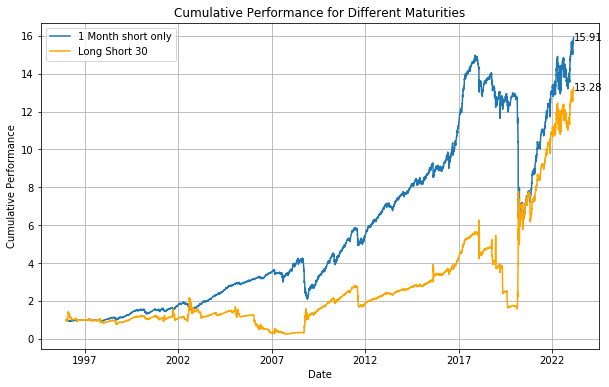

In [207]:
# Plotting the cumulative performances
plt.figure(figsize=(10, 6))

# Plot each line for different durations
plt.plot(returns_short['Date'], returns_short['cumulative_performance_1'], label='1 Month short only')
# Add text annotations for the end value of each line
end_value = returns_short['cumulative_performance_1'].iloc[-1]
plt.text(returns_short['Date'].iloc[-1], end_value, f'{end_value:.2f}', va='center', ha='left')

# Add the line from 'returns_long_short_30'
plt.plot(returns_long_short_30['Date'], returns_long_short_30['cumulative_returns'], color='orange', label='Long Short 30')
# Add text annotations for the end value of each line
end_value = returns_long_short_30['cumulative_returns'].iloc[-1]
plt.text(returns_long_short_30['Date'].iloc[-1], end_value, f'{end_value:.2f}', va='center', ha='left')

#STRADDLE_RET['Date'] = pd.to_datetime(STRADDLE_RET['Date']) applied above
years = pd.date_range(start='1996-01-05', end='2023-02-27', freq='5YS')  # Generating year starts
plt.xticks(years, [year.year for year in years])

#plt.axvline(pd.to_datetime('2020-03-16'), color='red', linestyle='--', label='16.03.2020')
#plt.axvline(pd.to_datetime('2020-03-16'), color='red', linestyle='--')
#plt.text(pd.to_datetime('2020-03-16'), plt.gca().get_ylim()[0], '16.03.2020', color='red', ha='left')

plt.title('Cumulative Performance for Different Maturities')
plt.xlabel('Date')
plt.ylabel('Cumulative Performance')
plt.legend()
plt.grid(True)
# Show the modified plot
plt.show()

This actually does not look comparable to the results he gets.
This needs to be further investigated.
A first idea is to not use the bottom quintile, but compute it with a grid, going from the 0.05 quantile to the 0.2 quantile.

## Try different quantiles
It looks like the strategy with the bottom quintile as the condition is long too often. An idea is the lower this condition so a lower value is taken.

In [208]:
# Quantiles to calculate
quantiles = [0.05, 0.1, 0.15, 0.2]

# Loop through quantiles
for q in quantiles:
    # Initialize a list to hold the boolean values for each row for the current quantile
    in_bottom_quantile = []

    # Calculate quantile based on historical data up until date 't' for each observation
    for i in range(len(SLOPE)):
        # Select the data up to the current row's date
        slope_data = SLOPE.loc[SLOPE['Date'] <= SLOPE.iloc[i]['Date']]

        if len(slope_data) > 1:
            current_value = slope_data.iloc[-1]['Slope']
            historical_values = slope_data.iloc[:-1]['Slope']
            quantile_value = historical_values.quantile(q)
            in_bottom_quantile.append(current_value <= quantile_value)
        else:
            in_bottom_quantile.append(True)  # Set as True if insufficient data for quantile calculation

    # Assign the list to a new column with a descriptive name
    SLOPE[f'InBottomQuantile_{q}'] = in_bottom_quantile
SLOPE = SLOPE.drop(columns='InBottomQuintile')
# Display the modified DataFrame
print(SLOPE)

           Date     Slope  InBottomQuantile_0.05  InBottomQuantile_0.1  \
0    1996-01-04 -1.045535                   True                  True   
1    1996-01-05 -0.985268                  False                 False   
2    1996-01-08 -1.009860                  False                 False   
3    1996-01-09 -1.187096                   True                  True   
4    1996-01-10 -1.159396                  False                  True   
...         ...       ...                    ...                   ...   
6830 2023-02-22 -0.133776                  False                 False   
6831 2023-02-23 -0.106842                  False                 False   
6832 2023-02-24 -0.077891                  False                 False   
6833 2023-02-27 -0.105548                  False                 False   
6834 2023-02-28 -0.126904                  False                 False   

      InBottomQuantile_0.15  InBottomQuantile_0.2  
0                      True                  True  
1      

In [209]:
# get some statistics to see the difference!
print("    Share of short (false) and long (true) for the 0.05-quantile")
value_counts = SLOPE[f'InBottomQuantile_{0.05}'].value_counts()
print(value_counts/sum(value_counts))

print("    Share of short (false) and long (true) for the 0.1-quantile")
value_counts = SLOPE[f'InBottomQuantile_{0.1}'].value_counts()
print(value_counts/sum(value_counts))

print("    Share of short (false) and long (true) for the 0.15-quantile")
value_counts = SLOPE[f'InBottomQuantile_{0.15}'].value_counts()
print(value_counts/sum(value_counts))

print("    Share of short (false) and long (true) for the 0.2-quantile")
value_counts = SLOPE[f'InBottomQuantile_{0.2}'].value_counts()
print(value_counts/sum(value_counts))

    Share of short (false) and long (true) for the 0.05-quantile
False    0.967652
True     0.032348
Name: InBottomQuantile_0.05, dtype: float64
    Share of short (false) and long (true) for the 0.1-quantile
False    0.950673
True     0.049327
Name: InBottomQuantile_0.1, dtype: float64
    Share of short (false) and long (true) for the 0.15-quantile
False    0.92579
True     0.07421
Name: InBottomQuantile_0.15, dtype: float64
    Share of short (false) and long (true) for the 0.2-quantile
False    0.903835
True     0.096165
Name: InBottomQuantile_0.2, dtype: float64


In [210]:
# SLOPE['Date'] = pd.to_datetime(SLOPE['Date']) done above already
# returns_long_correct['Date'] = pd.to_datetime(returns_long_correct['Date'])
# STRADDLE_RET['Date'] = pd.to_datetime(STRADDLE_RET['Date']) applied above already
#merge the datasets
returns_long_short_30 = pd.merge(returns_long[['Date', 'return_30']], returns_short[['Date','r_v_30']], on='Date', how='inner')
returns_long_short_30 = returns_long_short_30.merge(SLOPE[['Date', 'InBottomQuantile_0.05',
                                                          'InBottomQuantile_0.1', 'InBottomQuantile_0.15',
                                                          'InBottomQuantile_0.2']], on='Date')
#shift to account for the look ahead bias
returns_long_short_30[['InBottomQuantile_0.05', 'InBottomQuantile_0.1', 'InBottomQuantile_0.15', 'InBottomQuantile_0.2']] = returns_long_short_30[['InBottomQuantile_0.05', 'InBottomQuantile_0.1', 'InBottomQuantile_0.15', 'InBottomQuantile_0.2']].shift(1)
returns_long_short_30.loc[0, ['InBottomQuantile_0.05', 'InBottomQuantile_0.1', 'InBottomQuantile_0.15', 'InBottomQuantile_0.2']] = True

In [211]:
quantiles = ['0.05', '0.1', '0.15', '0.2']

for quantile in quantiles:
    condition_col = f'InBottomQuantile_{quantile}'
    return_long = f'return_30'
    return_short = f'r_v_30'

    # Condition: If the current quantile column is True, use the 'return_30' column, otherwise 'r_v_30'
    condition = returns_long_short_30.apply(lambda row: row[return_long] if row[condition_col] else row[return_short], axis=1)

    # Calculate cumulative returns based on the condition
    cumulative_return = (1 + condition).cumprod()
    returns_long_short_30[f'cumulative_returns_{quantile}'] = cumulative_return

#returns_long_short_30

Date  return_30    r_v_30 InBottomQuantile_0.05  \
0    1996-01-05  -0.047362  0.002855                  True   
1    1996-01-08  -0.050125  0.003020                 False   
2    1996-01-09   0.352578 -0.020640                 False   
3    1996-01-10   0.120899 -0.008543                  True   
4    1996-01-11  -0.096908  0.007298                 False   
...         ...        ...       ...                   ...   
6825 2023-02-21   0.074649 -0.007389                 False   
6826 2023-02-22  -0.046649  0.005773                 False   
6827 2023-02-23  -0.043014  0.005049                 False   
6828 2023-02-24  -0.000871  0.000285                 False   
6829 2023-02-27  -0.052136  0.005769                 False   

     InBottomQuantile_0.1 InBottomQuantile_0.15 InBottomQuantile_0.2  \
0                    True                  True                 True   
1                   False                 False                False   
2                   False                 False                False   
3                    True                  True                 True   
4                    True                  True                 True   
...                   ...                   ...                  ...   
6825                False                 False                False   
6826                False                 False                False   
6827                False                 False                False   
6828                False                 False                False   
6829                False                 False                False   

      cumulative_returns_0.05  cumulative_returns_0.1  \
0                    0.952638                0.952638   
1                    0.955514                0.955514   
2                    0.935792                0.935792   
3                    1.048929                1.048929   
4                    1.056584                0.947280   
...                       ...                     ...   
6825                90.128522               79.952384   
6826                90.648835               80.413950   
6827                91.106555               80.819990   
6828                91.132481               80.842989   
6829                91.658189               81.309341   

      cumulative_returns_0.15  cumulative_returns_0.2  
0                    0.952638                0.952638  
1                    0.955514                0.955514  
2                    0.935792                0.935792  
3                    1.048929                1.048929  
4                    0.947280                0.947280  
...                       ...                     ...  
6825                40.565285               13.060392  
6826                40.799468               13.135790  
6827                41.005480               13.202117  
6828                41.017149               13.205874  
6829                41.253761               13.282054  

[6830 rows x 11 columns]

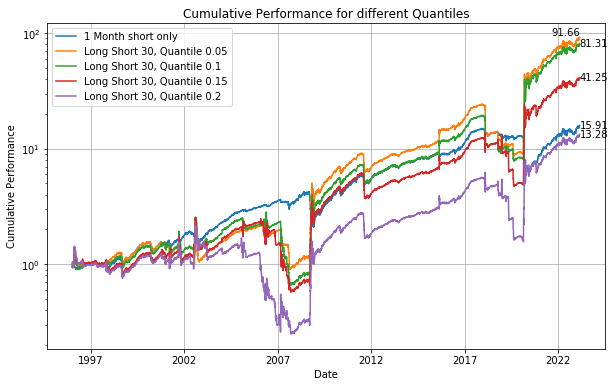

In [212]:
# Plotting the cumulative performances
plt.figure(figsize=(10, 6))
# Plot the short only cumulative performance
plt.plot(returns_short['Date'], returns_short['cumulative_performance_1'], label='1 Month short only')
# Add text annotations for the end value of each line
end_value = returns_short['cumulative_performance_1'].iloc[-1]
plt.text(returns_short['Date'].iloc[-1], end_value, f'{end_value:.2f}', va='center', ha='left')

# Plot line for different quantiles
quantiles = ['0.05', '0.1', '0.15', '0.2']
for quantile in quantiles:
    cumulative_col = f'cumulative_returns_{quantile}'
    plt.plot(returns_long_short_30['Date'], returns_long_short_30[cumulative_col], label=f'Long Short 30, Quantile {quantile}')

    # Add text annotations for the end value of each line
    end_value = returns_long_short_30[cumulative_col].iloc[-1]
    if quantile == '0.05':
        plt.text(returns_long_short_30['Date'].iloc[-1], end_value, f'{end_value:.2f}', va='bottom', ha='right')
    else:
        plt.text(returns_long_short_30['Date'].iloc[-1], end_value, f'{end_value:.2f}', va='center', ha='left')

years = pd.date_range(start='1996-01-05', end='2023-02-27', freq='5YS')  # Generating year starts
plt.xticks(years, [year.year for year in years])

# Add vertical line(s) or any other annotations as needed
# plt.axvline(pd.to_datetime('2020-03-16'), color='red', linestyle='--', label='16.03.2020')
# plt.axvline(pd.to_datetime('2020-03-16'), color='red', linestyle='--')
# plt.text(pd.to_datetime('2020-03-16'), plt.gca().get_ylim()[0], '16.03.2020', color='red', ha='left')

plt.title('Cumulative Performance for different Quantiles')
plt.xlabel('Date')
plt.ylabel('Cumulative Performance')
plt.yscale('log')  # Set the y-axis to log scale
plt.legend()
plt.grid(True)

# Show the modified plot
plt.show()

## Comparison to his data
Data import has been done above in the introduction.

In [213]:
SLOPE_given = SLOPE_given[['Date', 'PC2']]

# Rename 'PC2' to 'Slope'
SLOPE_given = SLOPE_given.rename(columns={'PC2': 'Slope'})
SLOPE_given

Date    Slope
0     1996-01-04 -0.88016
1     1996-01-05 -0.83101
2     1996-01-08 -0.85582
3     1996-01-09 -1.05163
4     1996-01-10 -1.03497
...          ...      ...
5907  2019-06-24 -0.32745
5908  2019-06-25 -0.36115
5909  2019-06-26 -0.35134
5910  2019-06-27 -0.39096
5911  2019-06-28 -0.24251

[5912 rows x 2 columns]

In [214]:
# Initialize a list to hold the boolean values for each row
in_bottom_quintile = []

# Calculate quantile based on historical data up until date 't' for each observation
for i in range(len(SLOPE_given)):
    # Select the data up to the current row's date
    slope_data = SLOPE_given.loc[SLOPE_given['Date'] <= SLOPE_given.iloc[i]['Date']]
    #print(i)
    #print("Slope: ",slope_data)
    if len(slope_data) > 1:
        current_value = slope_data.iloc[-1]['Slope']
        #print("Current value: ", current_value)
        historical_values = slope_data.iloc[:-1]['Slope']
        #print("Historical values: ", historical_values)
        quantile = historical_values.quantile(0.2)
        #print('Quantile: ', quantile)
        in_bottom_quintile.append(current_value <= quantile)
        #print(f"True/False_{i}: ", in_bottom_quintile)
    else:
        in_bottom_quintile.append(True)  # Set as True if insufficient data for quantile calculation

# Assign the list to a new column 'InBottomQuintile'
SLOPE_given['InBottomQuintile'] = in_bottom_quintile

In [215]:
print("    Share of short (false) and long (true) for the bottom quintile")
value_counts = SLOPE_given['InBottomQuintile'].value_counts()
print(value_counts/sum(value_counts))

    Share of short (false) and long (true) for the bottom quintile
False    0.910183
True     0.089817
Name: InBottomQuintile, dtype: float64


In [216]:
#merge the datasets
SLOPE_given['Date'] = pd.to_datetime(SLOPE_given['Date'])
returns_long_short_30 = STRADDLE_RET_given[['Date', 'r_1^{straddle}', 'r_1^{short straddle}']]
returns_long_short_30 = returns_long_short_30.merge(SLOPE_given[['Date', 'InBottomQuintile']], on='Date')
#shift to account for the look ahead bias
returns_long_short_30['InBottomQuintile'] = returns_long_short_30['InBottomQuintile'].shift(1)
returns_long_short_30['InBottomQuintile'][0] = True #set first value manually
#print(returns_long_short_30)

           Date  r_1^{straddle}  r_1^{short straddle} InBottomQuintile
0    1996-01-05        -0.04067               0.00500             True
1    1996-01-08        -0.01795               0.00224            False
2    1996-01-09         0.34233              -0.04098            False
3    1996-01-10         0.00968              -0.00139             True
4    1996-01-11        -0.09191               0.01410             True
...         ...             ...                   ...              ...
5906 2019-06-24        -0.05374               0.00788            False
5907 2019-06-25         0.02155              -0.00323            False
5908 2019-06-26        -0.03581               0.00578            False
5909 2019-06-27        -0.01815               0.00292            False
5910 2019-06-28        -0.00534               0.00083            False

[5911 rows x 4 columns]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [217]:
# Condition: If the 'condition_column' is True, use 'return_30', otherwise 'r_v_30'
condition = returns_long_short_30.apply(lambda row: row['r_1^{straddle}'] if row['InBottomQuintile'] else row['r_1^{short straddle}'], axis=1)
# Calculate cumulative returns based on the condition
cumulative_return = (1 + condition).cumprod()
returns_long_short_30['cumulative_returns'] = cumulative_return
#returns_long_short_30

Date  r_1^{straddle}  r_1^{short straddle} InBottomQuintile  \
0    1996-01-05        -0.04067               0.00500             True   
1    1996-01-08        -0.01795               0.00224            False   
2    1996-01-09         0.34233              -0.04098            False   
3    1996-01-10         0.00968              -0.00139             True   
4    1996-01-11        -0.09191               0.01410             True   
...         ...             ...                   ...              ...   
5906 2019-06-24        -0.05374               0.00788            False   
5907 2019-06-25         0.02155              -0.00323            False   
5908 2019-06-26        -0.03581               0.00578            False   
5909 2019-06-27        -0.01815               0.00292            False   
5910 2019-06-28        -0.00534               0.00083            False   

      cumulative_returns  
0               0.959330  
1               0.961479  
2               0.922077  
3               0.931003  
4               0.845435  
...                  ...  
5906          183.336141  
5907          182.743965  
5908          183.800225  
5909          184.336922  
5910          184.489922  

[5911 rows x 5 columns]

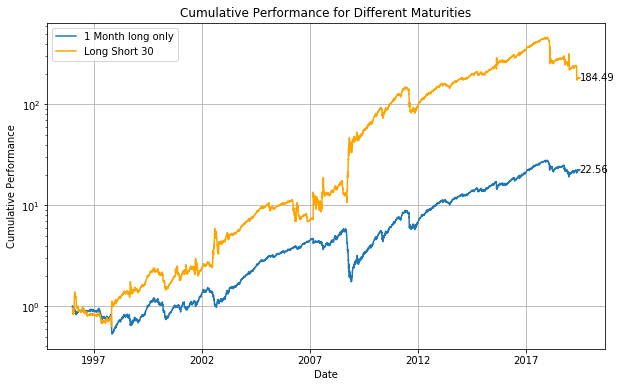

In [218]:
# Plotting the cumulative performances
#this is not finished yet and still needs some working!
plt.figure(figsize=(10, 6))

# Plot short only
plt.plot(STRADDLE_RET_given['Date'], STRADDLE_RET_given['cumulative_performance_1'], label=f'1 Month long only')

# Add text annotations for the end value of each line
end_value = STRADDLE_RET_given['cumulative_performance_1'].iloc[-1]
plt.text(STRADDLE_RET_given['Date'].iloc[-1], end_value, f'{end_value:.2f}', va='center', ha='left')

# Add the line from 'returns_long_short_30'
plt.plot(returns_long_short_30['Date'], returns_long_short_30['cumulative_returns'], color='orange', label='Long Short 30')
# Add text annotations for the end value of each line
end_value = returns_long_short_30['cumulative_returns'].iloc[-1]
plt.text(returns_long_short_30['Date'].iloc[-1], end_value, f'{end_value:.2f}', va='center', ha='left')

#STRADDLE_RET_given['Date'] = pd.to_datetime(STRADDLE_RET_given['Date'])
years = pd.date_range(start='1996-01-05', end='2019-12-31', freq='5YS')  # Generating year starts
plt.xticks(years, [year.year for year in years])

#plt.axvline(pd.to_datetime('2020-03-16'), color='red', linestyle='--', label='16.03.2020')
#plt.axvline(pd.to_datetime('2020-03-16'), color='red', linestyle='--')
#plt.text(pd.to_datetime('2020-03-16'), plt.gca().get_ylim()[0], '16.03.2020', color='red', ha='left')

plt.title('Cumulative Performance for Different Maturities')
plt.xlabel('Date')
plt.ylabel('Cumulative Performance')
plt.yscale('log')  # Set the y-axis to log scale
plt.legend()
plt.grid(True)
# Show the modified plot
plt.show()

# Option 2: Split the data in training and test data
Instead of getting the condition based on the expanding time window, we could also split the data into training and test sets. The training set is used to calculate the quintile. Then, the test data is comparing the current slope value to this quintile. If it is in the lower quintile, we take the long return, if it is not, we take the short return.